<a href="https://colab.research.google.com/github/jrosko/Cyano_ImgAnalysis/blob/main/segment_filaments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The aim here is to get labelled, single pixel wide skeletons of individual filaments. These are later used for calculating length and tracking points of interest.

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pims
import cv2
import sys
#from scipy import ndimage
from skimage.morphology import skeletonize
sys.path.insert(0, 'D:\\Cyano_ImgAnalysis\\functions\\')
# Import my functions library
import filaments as fil

## Load a test stack
## We're using the pims package to load tif stacks

path = r'D:\\Data_WW\\pos_6\\pos6_crop_1\\'
frames = pims.open(path + r'\*.tif')

Open one of the frames and pre-process it (denoise, threshold, morph. opening). Showing both original and pre-processed side by side.

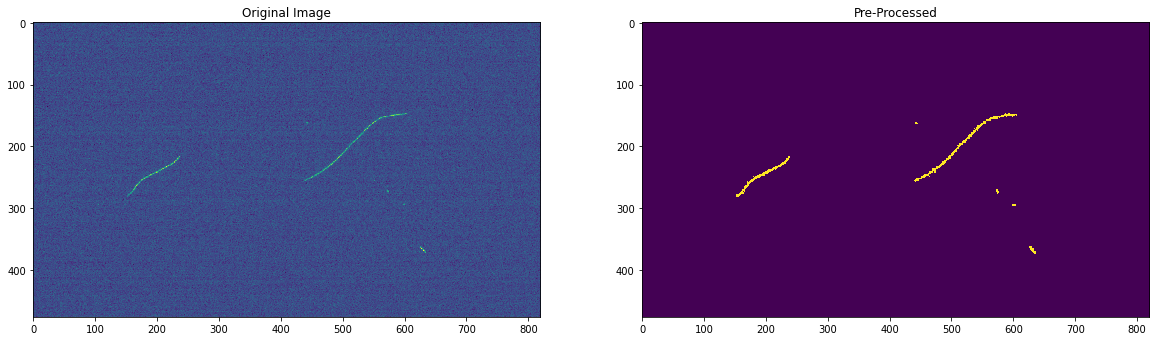

In [115]:
image = fil.pre_process(frames[11], 9)

fig, ax = plt.subplots(1,2, figsize = (20,16))
ax[0].imshow(frames[11], interpolation = 'none')
ax[0].set_title('Original Image')
ax[1].imshow(image, interpolation = 'none')
ax[1].set_title('Pre-Processed')

plt.show()

Now I want to label the elements in the pre-processed image. After, I will filter by surface area and reject small ones, aiming to keep only the three largest sausages, for which I am sure that they are filaments

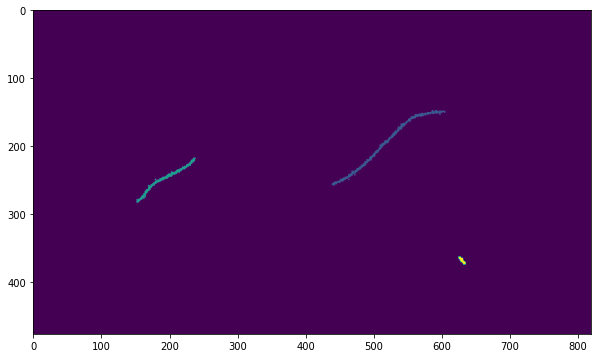

In [116]:
# We use connected components with stats to label the image
retval,labels,stats,centroid=cv2.connectedComponentsWithStats(image)

# Label candidates
candidates  = np.argwhere(stats[:,-1]>50).flatten()[1:] # stats[:,-1] is last column, area. candidates[0] is background

# I want a mask that gives True when a label is not an element of candidates
filter_mask = np.logical_not(np.isin(labels, candidates))

# Set non candidates to background value
labels[filter_mask]=0

plt.figure(figsize=(10,10))
plt.imshow(labels)
plt.show()

Now, I want to extract/segment the individual labelled filaments (the "connected components") - together with information about their relative locations within the image above.

The "stats" output of cv2.connectedComponents... contains all the neccesary information.
For example, below is the "stats" for the current frame. Each row is a labelled component, and columns are (left to right):

* The leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.

* The topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
	
* The horizontal size of the bounding box.

* The vertical size of the bounding box.

* The total area (in pixels) of the connected component. 


In [117]:
print('The statistics matrix for the current example:')
print(stats)

The statistics matrix for the current example:
[[     0      0    820    476 388940]
 [     0      0      2      2      4]
 [   439    147    167    111    807]
 [   441    162      5      3     12]
 [   152    217     87     66    452]
 [   571    270      5      8     25]
 [   598    293      5      4     17]
 [   625    362     11     12     63]]


We have already filtered the components by absolute minimum mass (50) and discarded the 0-th index which is the background. The resulting row-indices, we will use to access further stats, are in the variable "candidates"

In [118]:
print('Candidates for Filaments are: ')
print(candidates)

Candidates for Filaments are: 
[2 4 7]


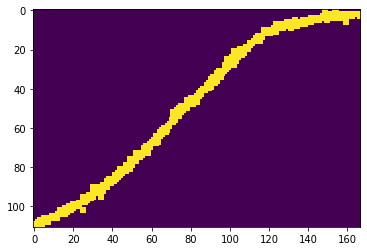

In [119]:
# Let's focus on the zeroth filament:

n=0
col_ind = stats[candidates][n][0]
row_ind = stats[candidates][n][1]
col_w = stats[candidates][n][2]
row_w = stats[candidates][n][3]

pixel_value = candidates[n] # n-th label will have integer n for it's pixel value
part_img = labels[row_ind : row_ind + row_w,col_ind : col_ind+col_w] # Bounding box

# only show pixels that are of "pixel_value"
pix_val_mask = part_img == pixel_value
pix_val_mask_inv = np.logical_not(pix_val_mask)

# set other labels present to background value
part_img[pix_val_mask_inv] = 0

part_img = np.uint8(part_img)
part_img = cv2.dilate(part_img, np.ones((2,2)), iterations = 1)

plt.imshow(part_img, interpolation='none')

The next thing I want is the filament skeleton. It will be a 1px thick line, passing through the center of the worm, which will be used to find the "middle point" of the worm and to calculate the length of the worm.

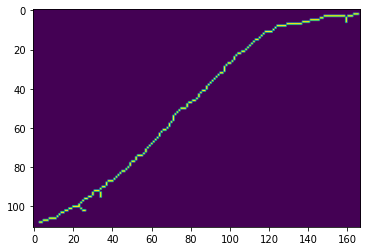

In [120]:
first_skeleton = skeletonize(part_img, method='lee')
plt.imshow(first_skeleton)

The skeleton's will usually have an odd branch or two coming from the side, or a fork at the very top. This needs pruning.
Pruning function + helper functions:

In [121]:
# test function for pruning
def prune_skeleton(skeleton_input):
    skeleton = np.copy(skeleton_input) # if i dont copy it actually changes first_skeleton
    skeleton = np.pad(skeleton,5, constant_values=(0)) # move this into pre process
    args = np.argwhere(skeleton >0 ).astype('uint8') # indices of non zero pixels
    one_n = [] # simple ends
    three_n = [] # forks
    for arg in args:
        nbors = nearest_neighbors(arg,skeleton)
        if nbors == 3:
            three_n.append(arg)
        elif nbors == 1:
            one_n.append(arg)
    one_n = np.array(one_n).astype(np.int32)
    three_n = np.array(three_n).astype(np.int32)
    ## fork can be two things, a offshoot in the middle of the line or the end fork
    ## let's deal with offshoots first
    porcodio = 0
    for nbor in three_n:
        distances = []
        for p in range(0, len(one_n)):
            dist = np.linalg.norm(nbor - one_n[p], ord=None)
            distances.append([dist,p])
        distances = np.array(distances)
        min_dist_ind = distances[np.argmin(distances[:,0])][1].astype(np.int16)
        min_dist_pt = one_n[min_dist_ind]
        # now we know the point closest to the 3-fork
        # let's begin from this point
        # very nearest nbors should be 
        found = 0
        current_pt = min_dist_pt
        while True:
            nearest_pt = nearest(skeleton, current_pt)
            if type(nearest_pt) == type(None):
                porcodio = 1
                break
            if np.all(current_pt == nbor):
                break
            else:
                skeleton[current_pt[0], current_pt[1]] = 0
                current_pt = nearest_pt
        #skeleton[min_dist_pt[0], min_dist_pt[1]]= 0
    if porcodio != 1:
        return skeleton
    else:
        return None

## helper functions

def nearest(image, point):
    very_near = point - np.array([[1,0],[-1,0],[0,1],[0,-1]])
    near = point - np.array([[1,1],[-1,-1],[-1,1],[1,-1]])
    rtn = 0
    found = 0
    if np.any(image[very_near[:,0], very_near[:,1]] > 0):
        for point in very_near:
            if image[point[0], point[1]] > 0:
                rtn = point
                found = 1
                break
    elif np.any(image[near[:,0], near[:,1]] > 0) and found == 0:
        for point in near:
            if image[point[0], point[1]] > 0:
                rtn = point
                found  = 1
                break
    if found == 1:
        return rtn 
    else:
        return None

def nearest_neighbors(index_pair,image):
    """
    Takes in the an index pair, belonging to arghwhere(image > 0), and the respective image.
    Interrogates a 3x3 lattice centred around the index_pair, in an anticlockwise way.
    Counts unique neighbours to the central element.
    Returns count of unique members
    """
    delta_i = np.array([[0,1], [0,0], [1,0], [2,0], [2,1], [2,2], [1,2], [0,2]]) - np.array([1,1]) 
    initial_nonzero = 0
    unique_count = 0
    prev_nonzero = 0
    for m in range(0, len(delta_i)):
        new_i = index_pair + delta_i[m] # 
        if image[new_i[0], new_i[1]] > 0: # Can't index image with [new_i] but need to separate the values
            if prev_nonzero == 0:
                unique_count = unique_count + 1
                prev_nonzero = 1
                if m == 0:
                    initial_nonzero = 1
                if m == len(delta_i)-1 and initial_nonzero == 1:
                    unique_count = unique_count - 1
        elif image[new_i[0], new_i[1]] == 0:
            prev_nonzero=0
    return unique_count

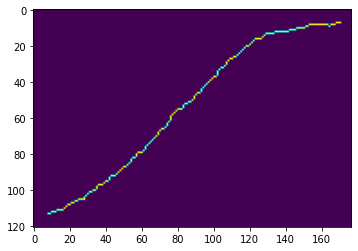

In [122]:
# Pruned Skeleton
skel_ = prune_skeleton(first_skeleton)
plt.imshow(skel_)

# Now something that operates on the whole stack 

Putting together a function that returns coordinates of skeleton points of good filament candidates, in the frame of reference of the original image/stack

In [123]:
def get_skeletons(input_frames,min_mass=50):
    """ returns args of skeleton points in the main image reference frame.
    the output is of kind out['frame']['mass']= xy points"""
    results_dict = {}

    for f in range(0, len(input_frames)):

        image = fil.pre_process(input_frames[f], 9)
        results_sub_dict = {}

        #### NEED TO PREPROCESS OR STH

        # We use connected components with stats to label the image
        retval,labels,stats,centroid=cv2.connectedComponentsWithStats(image)

        # Label candidates
        candidates  = np.argwhere(stats[:,-1]>min_mass).flatten()[1:] # stats[:,-1] is last column, area. candidates[0] is background

        # I want a mask that gives True when a label is not an element of candidates
        filter_mask = np.logical_not(np.isin(labels, candidates))

        # Set non candidates to background value
        labels[filter_mask]=0
        
        # Loop over good candidates

        for n in range(0, len(candidates)):
            col_ind = stats[candidates][n][0]
            row_ind = stats[candidates][n][1]
            col_w = stats[candidates][n][2]
            row_w = stats[candidates][n][3]
            mass = stats[candidates][n][-1]

            pixel_value = candidates[n] # n-th label will have integer n for it's pixel value
            part_img = labels[row_ind : row_ind + row_w,col_ind : col_ind+col_w] # Bounding box

            #only show pixels that are of "pixel_value"
            pix_val_mask = part_img == pixel_value
            pix_val_mask_inv = np.logical_not(pix_val_mask)

            # set other labels present to background value
            part_img[pix_val_mask_inv] = 0

            part_img = np.uint8(part_img)
            part_img = cv2.dilate(part_img, np.ones((2,2)), iterations = 1)

            skeleton = skeletonize(part_img, method='lee')

            skeleton = prune_skeleton(skeleton)

            if type(skeleton)!=type(None):
                pts = np.argwhere(skeleton>0)
                offset = np.array([row_ind, col_ind])-5
                pts = pts + offset
                results_sub_dict[str(mass)] = pts
        
        results_dict[str(f)] = results_sub_dict
    
    return results_dict

Run the output and display the result for just one frame

In [124]:
skels = get_skeletons(frames[0:40],min_mass=50)
skels['11'].keys() # will give masses in skels['1']


dict_keys(['807', '452', '63'])

Text(0.5, 1.0, 'Exaggerated-width single pixel wide skeletons')

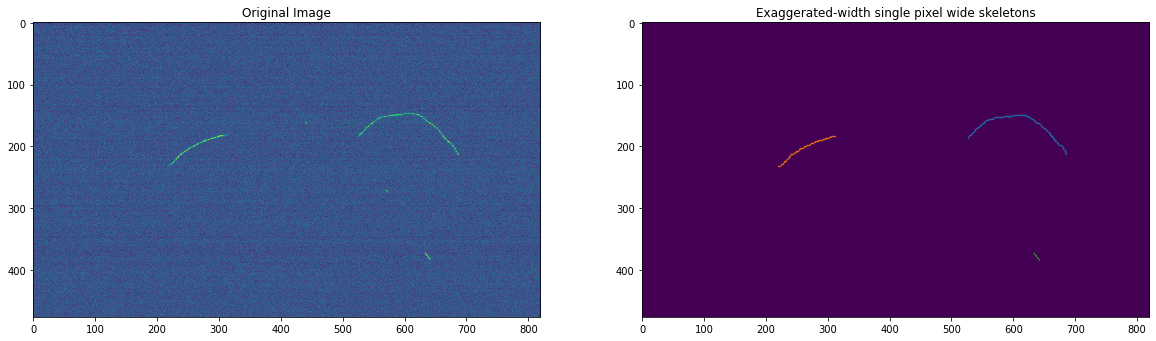

In [125]:
s1 = skels['1']['843']
blank_img = np.zeros(frames[11].shape)
fig, ax = plt.subplots(1,2, figsize = (20,16))
ax[0].imshow(frames[1], interpolation = 'none')
ax[0].set_title('Original Image')
ax[1].imshow(blank_img)
for key in skels['1'].keys():
    s = skels['1'][key]
    ax[1].plot(s[:,1], s[:,0] ,'.', markersize=0.7)

ax[1].set_title('Exaggerated-width single pixel wide skeletons')



To analyse multiple frames, we will have to let the mass parameter vary a little. So we're making a mass histogram to see if the frame-to-frame mass distributions are well separated

Note:
Frame 16 here didn't find the biggest skeleton when there is obviously nothing wrong with it,
that is because the skeleton was rejected due to a loop on it that couldnt be pruned,
will look into

In [134]:
masses = []
for k in range(0, len(skels)):
    masses.append(list(skels[str(k)].keys()))

#masses = np.array([m.]])
#n, bins, patches = plt.hist(masses.flat, bins = 20)
#plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

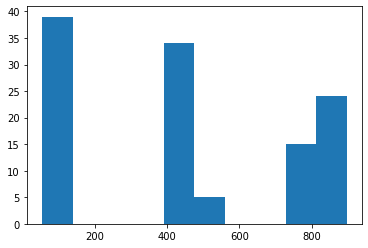

In [148]:
masses_flat = [int(item) for sublist in masses for item in sublist] # need to remember that till now mass was string
masses_flat = np.array(masses_flat)
n, bins, patches = plt.hist(masses_flat)
plt.show

Masses are well separated and we will be able to use them to segment filaments